# Hypothesis Testing with Men's and Women's Soccer Matches

You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question you are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin
from scipy.stats import mannwhitneyu

## Are more goals scored in women's international soccer matches than men's?

### Preliminary analysis of data, filtering, and feature creation

In [2]:
# Read in CSV, transform date column to be datetime object, create conditionals for filtering, filter women's results data frame 
women_results = pd.read_csv('women_results.csv')
women_results['date'] = pd.to_datetime(women_results['date'], format='%Y-%m-%d') 
w_conditon_tournament = women_results['tournament'] == 'FIFA World Cup'
w_condition_2002_on = women_results['date'].dt.year >= 2002
women_results_FIFA_WC_2002_on = women_results[w_conditon_tournament & w_condition_2002_on]

# Read in CSV, transform date column to be datetime object, create conditionals for filtering, filter men's results data frame 
men_results = pd.read_csv('men_results.csv')
men_results['date'] = pd.to_datetime(men_results['date'], format='%Y-%m-%d') 
m_conditon_tournament = men_results['tournament'] == 'FIFA World Cup'
m_condition_2002_on = men_results['date'].dt.year >= 2002
men_results_FIFA_WC_2002_on = men_results[m_conditon_tournament & m_condition_2002_on]

# Create a feature in both of the data frames showing whether the game was played by females or males 
men_results_FIFA_WC_2002_on['sex'] = 'male'
women_results_FIFA_WC_2002_on['sex'] = 'female'

display(men_results_FIFA_WC_2002_on.head())
display(women_results_FIFA_WC_2002_on.head())

C:\Users\widej\AppData\Local\Temp\ipykernel_3540\197953218.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_results_FIFA_WC_2002_on['sex'] = 'male'
C:\Users\widej\AppData\Local\Temp\ipykernel_3540\197953218.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women_results_FIFA_WC_2002_on['sex'] = 'female'


,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament,sex
25164,25164,2002-05-31,France,Senegal,0,1,FIFA World Cup,male
25165,25165,2002-06-01,Germany,Saudi Arabia,8,0,FIFA World Cup,male
25166,25166,2002-06-01,Republic of Ireland,Cameroon,1,1,FIFA World Cup,male
25167,25167,2002-06-01,Uruguay,Denmark,1,2,FIFA World Cup,male
25168,25168,2002-06-02,Argentina,Nigeria,1,0,FIFA World Cup,male


,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament,sex
1600,1600,2003-09-20,Nigeria,North Korea,0,3,FIFA World Cup,female
1601,1601,2003-09-20,Norway,France,2,0,FIFA World Cup,female
1602,1602,2003-09-20,Germany,Canada,4,1,FIFA World Cup,female
1603,1603,2003-09-20,Japan,Argentina,6,0,FIFA World Cup,female
1604,1604,2003-09-21,United States,Sweden,3,1,FIFA World Cup,female


In [3]:
men_results_FIFA_WC_2002_on.info()
print('\n')
women_results_FIFA_WC_2002_on.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384 entries, 25164 to 44352
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  384 non-null    int64         
 1   date        384 non-null    datetime64[ns]
 2   home_team   384 non-null    object        
 3   away_team   384 non-null    object        
 4   home_score  384 non-null    int64         
 5   away_score  384 non-null    int64         
 6   tournament  384 non-null    object        
 7   sex         384 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 27.0+ KB


<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1600 to 4469
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  200 non-null    int64         
 1   date        200 non-null    datetime64[ns]
 2   home_team   200 non-null    object        


In [4]:
# Merge the Men and women data frames togther using concat 
FIFA_WC_results_2002_on = pd.concat([men_results_FIFA_WC_2002_on, women_results_FIFA_WC_2002_on])

# Create the total score feature
FIFA_WC_results_2002_on['total_score'] = FIFA_WC_results_2002_on['home_score'] + FIFA_WC_results_2002_on['away_score']

# Create the year feature
FIFA_WC_results_2002_on['year'] = FIFA_WC_results_2002_on['date'].dt.year

display(FIFA_WC_results_2002_on.shape)
FIFA_WC_results_2002_on.info()
FIFA_WC_results_2002_on.head()

(584, 10)

<class 'pandas.core.frame.DataFrame'>
Index: 584 entries, 25164 to 4469
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   584 non-null    int64         
 1   date         584 non-null    datetime64[ns]
 2   home_team    584 non-null    object        
 3   away_team    584 non-null    object        
 4   home_score   584 non-null    int64         
 5   away_score   584 non-null    int64         
 6   tournament   584 non-null    object        
 7   sex          584 non-null    object        
 8   total_score  584 non-null    int64         
 9   year         584 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(4), object(4)
memory usage: 47.9+ KB


,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament,sex,total_score,year
25164,25164,2002-05-31,France,Senegal,0,1,FIFA World Cup,male,1,2002
25165,25165,2002-06-01,Germany,Saudi Arabia,8,0,FIFA World Cup,male,8,2002
25166,25166,2002-06-01,Republic of Ireland,Cameroon,1,1,FIFA World Cup,male,2,2002
25167,25167,2002-06-01,Uruguay,Denmark,1,2,FIFA World Cup,male,3,2002
25168,25168,2002-06-02,Argentina,Nigeria,1,0,FIFA World Cup,male,1,2002


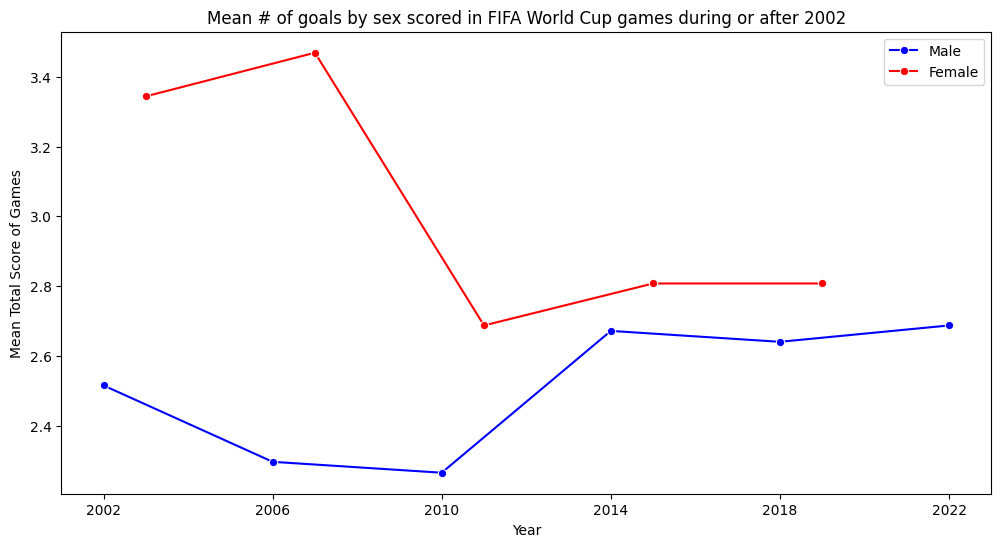

<Figure size 640x480 with 0 Axes>

In [5]:
male_grouped_df_mean_score_by_year = FIFA_WC_results_2002_on[FIFA_WC_results_2002_on['sex']=='male'].groupby(['year'])['total_score'].mean().reset_index()

female_grouped_df_mean_score_by_year = FIFA_WC_results_2002_on[FIFA_WC_results_2002_on['sex']=='female'].groupby(['year'])['total_score'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=male_grouped_df_mean_score_by_year, x='year', y='total_score', color='blue', label='Male', marker='o')
sns.lineplot(data=female_grouped_df_mean_score_by_year, x='year', y='total_score', color='red', label='Female', marker='o')
plt.ylabel('Mean Total Score of Games')
plt.xlabel('Year')
plt.xticks(male_grouped_df_mean_score_by_year['year'].astype(int))
plt.legend()
plt.title('Mean # of goals by sex scored in FIFA World Cup games during or after 2002')
plt.show()
plt.clf()

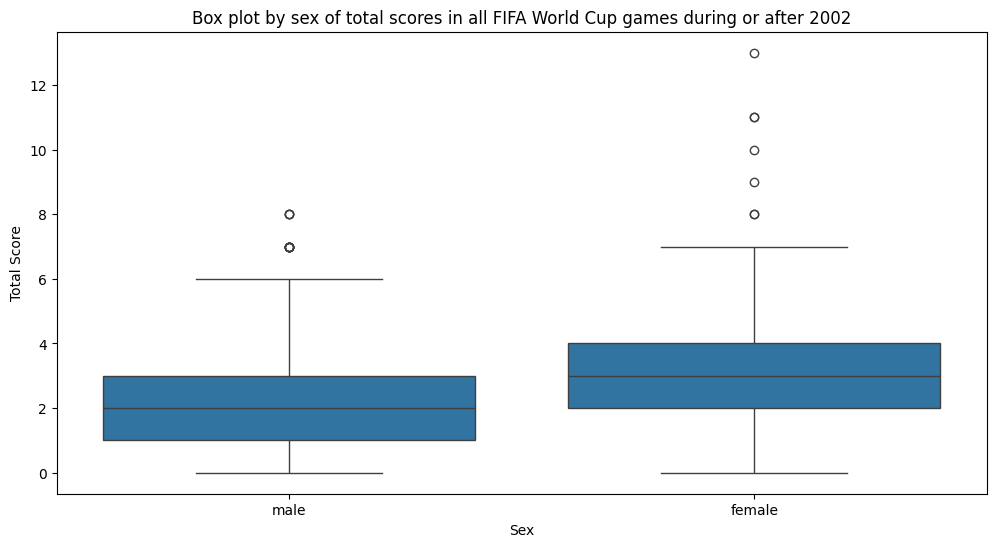

<Figure size 640x480 with 0 Axes>

In [6]:
plt.figure(figsize=(12,6))
sns.boxplot(data=FIFA_WC_results_2002_on, x='sex', y='total_score')
plt.title('Box plot by sex of total scores in all FIFA World Cup games during or after 2002')
plt.xlabel('Sex')
plt.ylabel('Total Score')
plt.show()
plt.clf()

Determine Normality of Goals scored for each group

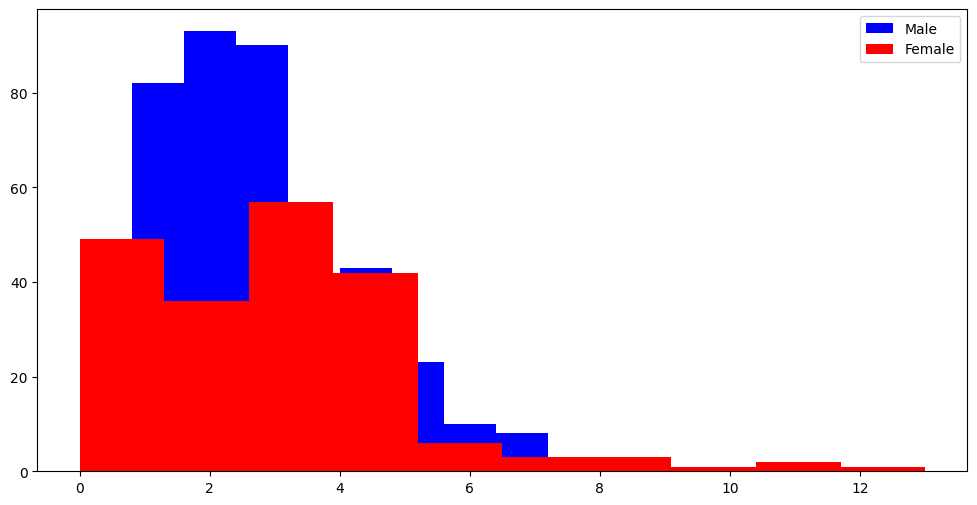

In [7]:
plt.figure(figsize=(12,6))
plt.hist(x=FIFA_WC_results_2002_on[FIFA_WC_results_2002_on['sex'] == 'male']['total_score'], label='Male', color='blue')
plt.hist(x=FIFA_WC_results_2002_on[FIFA_WC_results_2002_on['sex'] == 'female']['total_score'], label='Female', color='red')
plt.legend()
plt.show()

Due to the total goals column not being normally distributed, it is good practice to use a non-parametric test. In this case, I will perform a Mann-Whitney U t-test.

In [8]:
# Preparing Data for test
FIFA_WC_results_2002_on_subset = FIFA_WC_results_2002_on[['total_score', 'sex']]
FIFA_WC_results_2002_on_subset_wide = FIFA_WC_results_2002_on_subset.pivot(columns='sex', values='total_score')

# Perform right-tailed MWU test
results = pingouin.mwu(x=FIFA_WC_results_2002_on_subset_wide['female'],
                       y=FIFA_WC_results_2002_on_subset_wide['male'],
                       alternative='greater'
                      )

# Extract p-value as a float from results
p_value = results['p-val'].values[0]

if p_value <= 0.01:
    result = 'reject'
else:
    result = 'fail to reject'
    
result_dict = {'p_val': p_value, 'result': result}

display(result_dict)

{'p_val': 0.005106609825443641, 'result': 'reject'}

C:\Users\widej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


I reject the null hypothesis that 'The mean number of goals scored in women's international soccer matches is the same as men's' at the specified significance level of 10%, indicating that there is sufficient evidence to support the alternative hypothesis: 'The mean number of goals scored in women's international soccer matches is greater than men's'.